# Untitled Notebook

What's this notebook about?

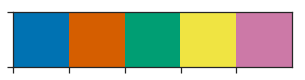

In [40]:
import sys
import os
from glob import glob
import random
from operator import and_
from functools import 
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [44]:
BLAST_COLNAMES = [
    'adapter_name', 'read_id', 'pident', 'length', 'mismatch', 'gapopen',
    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'
]
CONVERTERS = {'evalue': lambda x: np.log10(float(x))}

THRESHOLDS = {
    'Match length > 10 nt': 'length > 10',
    'Log10 E Value < 2': 'evalue < 2',
    'Adapter matches directly after alignment': '(sstart == 1 | send == 1)'    
}

PASS_MAP = {True: 'Passes', False: 'Fails'}

def read_blast_data(blast_tsv_fn):
    blast_data = pd.read_csv(
        blast_tsv_fn, sep='\t',
        names=BLAST_COLNAMES,
        converters=CONVERTERS
    )
    for i, name in enumerate(THRESHOLDS):
        statement = ' & '.join([t for t in list(THRESHOLDS.values())[:i + 1]])
        agg_thresh = blast_data.eval(statement)
        blast_data[name] = agg_thresh.map(PASS_MAP)
    return blast_data



datasets = {
    'Col-0 2916_Adapter': '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/adapter_blast/TAIR10/201902_col0_2916_5adapter_exp2_five-prime_softclipped_blast_hits.tsv',
    'Col-0 2916_No Adapter': '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/adapter_blast/TAIR10/201901_col0_2916_five-prime_softclipped_blast_hits.tsv',
    'Col-0 2918_Adapter': '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/adapter_blast/TAIR10/201902_col0_2918_5adapter_five-prime_softclipped_blast_hits.tsv',
    'Col-0 2918_No Adapter': '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/adapter_blast/TAIR10/201901_col0_2918_five-prime_softclipped_blast_hits.tsv'
}

datasets = {sn: read_blast_data(bh) for sn, bh in datasets.items()}


In [48]:
dataset_filter_counts = defaultdict(dict)
thresh_cols = list(THRESHOLDS.keys())

for sn, df in datasets.items():
    sn, has_adapter = sn.split('_')
    agg = df[thresh_cols].apply(pd.value_counts)
    dataset_filter_counts[sn][has_adapter] = agg.T

for sn, df in dataset_filter_counts.items():
    df = pd.concat(df, axis=1)
    df['Signal to Noise'] = ((df[('Adapter', 'Passes')] / df[('Adapter', 'Fails')]) /
                             (df[('No Adapter', 'Passes')] / df[('No Adapter', 'Fails')]))
    dataset_filter_counts[sn] = df

dataset_filter_counts = pd.concat(dataset_filter_counts, axis=1)

In [49]:
dataset_filter_counts['Col-0 2916']

Adapter         No Adapter         \
                                           Fails  Passes      Fails Passes   
Match length > 10 nt                       58078  211786      47548  11427   
Log10 E Value < 2                          76926  192938      57874   1101   
Adapter matches directly after alignment  198296   71568      58936     39   

                                         Signal to Noise  
                                                          
Match length > 10 nt                           15.173495  
Log10 E Value < 2                             131.838060  
Adapter matches directly after alignment      545.407338

In [50]:
dataset_filter_counts['Col-0 2918']

Adapter         No Adapter         \
                                           Fails  Passes      Fails Passes   
Match length > 10 nt                       37631  342158     100791  12653   
Log10 E Value < 2                          60605  319184     112781    663   
Adapter matches directly after alignment  266812  112977     113429     15   

                                         Signal to Noise  
                                                          
Match length > 10 nt                           72.428449  
Log10 E Value < 2                             895.890786  
Adapter matches directly after alignment     3201.971959

In [52]:
with pd.ExcelWriter('adapter_filtering_res.xlsx') as xlw:
    dataset_filter_counts['Col-0 2916'].to_excel(xlw, sheet_name='Col0 2916')
    dataset_filter_counts['Col-0 2918'].to_excel(xlw, sheet_name='Col0 2918')